In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing pyspark**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=621310a203ab6938cce47180968ab7ce1f97e766c148bcdc10d0afa68be69c8a
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
!pip install openpyxl

**Initializing spark session**

In [ ]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('Assessment').getOrCreate()

In [ ]:
spark

In [ ]:
import warnings
warnings.filterwarnings("ignore")

**Data Set**

In [ ]:
#data set (shareable google drive link) - https://docs.google.com/spreadsheets/d/1Qx_rvu0Hcj7axS1ZL3906E0KhmFP1OeX/edit?usp=sharing&ouid=109584944909974468723&rtpof=true&sd=true


# read the excel file

data_file = "/content/drive/MyDrive/surge/DS_DE Internship - GS Sales Data 2022.v2 (1).xlsx"
import pandas as pd

sales_data = pd.read_excel(data_file,sheet_name= "GS Sales Data", engine = 'openpyxl' )
daily_target = pd.read_excel(data_file,sheet_name="Daily Target" , engine = 'openpyxl' )

#Replacing the double quotation mark in product name

sales_data['Product Name'] = sales_data['Product Name'].str.replace('"',' ')

#covert the files To csv format
path = "/content/drive/MyDrive/surge/"
sales_data.to_csv(path+'sales_data.csv')
daily_target.to_csv(path+'daily_target.csv')

**Load the Data into Spark Dataframes**

In [ ]:
sales_data = spark.read.csv(path+'sales_data.csv',sep = ',',header = True,inferSchema=True,)
daily_target = spark.read.csv(path+'daily_target.csv',sep = ',',header = True,inferSchema=True)


In [ ]:
sales_data.show()

+---+------+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+------------------+--------+--------+-------------------+--------+
|_c0|Row ID|      Order ID|Order Date|Order_Week| Ship Date|Ship_Week|     Ship Mode|Customer ID|   Customer Name|    Segment|Country/Region|        City|State/Province|Postal Code| Region| Regional Manager|     Product ID|       Category|Sub-Category|        Product Name|             Sales|Quantity|Discount|             Profit|Returned|
+---+------+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+--------------+------------+--------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+------------------+--------+--------+----------

**Drop Row ID column from the dataset**

In [ ]:
sales_data = sales_data.drop('Row ID')
daily_target = daily_target.drop('Row ID')

In [ ]:
#check the data schema

sales_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship Mode: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State/Province: string (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional Manager: string (nullable = true)
 |-- Product ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- R

**change the data types**





In [ ]:
sales_data.select('Returned').distinct().show()

+--------+
|Returned|
+--------+
|    null|
|     Yes|
+--------+



In [ ]:
#replace null value by 0
sales_data = sales_data.fillna({'Returned':'0'})

In [ ]:
#replace 'yes" by 1 in retunreed column
#change the data type of Retuned string to IntegerType()
from pyspark.sql.types import IntegerType
sales_data = sales_data.replace(['Yes'], ["1"], 'Returned')
sales_data = sales_data.withColumn("Returned", sales_data["Returned"].cast(IntegerType()))


In [ ]:
sales_data.select('Returned').distinct().show()

+--------+
|Returned|
+--------+
|       1|
|       0|
+--------+



In [ ]:
#change the column names
Header_list = ["_co", "Order_ID", "Order_Date", "Order_Week", "Ship_Date", "Ship_Week",
               "Ship_Mode", "Customer_ID", "Customer_Name", "Segment", "Country",
               "City", "State", "Postal_Code", "Region", "Regional_Manager",
               "Product_ID", "Category", "Sub_Category", "Product_Name", "Sales",
               "Quantity", "Discount", "Profit","Returned"]

sales_data = sales_data.toDF(*Header_list)

In [ ]:
sales_data.show()

+---+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+-------------+------------+------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+------------------+--------+--------+-------------------+--------+
|_co|      Order_ID|Order_Date|Order_Week| Ship_Date|Ship_Week|     Ship_Mode|Customer_ID|   Customer_Name|    Segment|      Country|        City|       State|Postal_Code| Region| Regional_Manager|     Product_ID|       Category|Sub_Category|        Product_Name|             Sales|Quantity|Discount|             Profit|Returned|
+---+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+-------------+------------+------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+------------------+--------+--------+-------------------+--------+
|  0|US-20

In [ ]:
#check whether returned products' sales and profits are sill consider?

return_check = sales_data.select("Sales","Profit","Returned").groupBy("Returned").sum("Sales","Profit").show()


+--------+------------------+-----------------+
|Returned|        sum(Sales)|      sum(Profit)|
+--------+------------------+-----------------+
|       1|180504.27790000002|23232.36149999998|
|       0| 2146030.076399955|269064.4531000004|
+--------+------------------+-----------------+



we can clearly see that if items are returned sales & profit are still calculated
so we have to change the values to 0 for them so their values will not be added to profit and sales


---



In [ ]:
from pyspark.sql import functions as F

# Use PySpark functions to conditionally update the columns
sales_data = sales_data.withColumn(
    "Sales",
    F.when(sales_data["Returned"] == 1, 0).otherwise(sales_data["Sales"])
).withColumn(
    "Quantity",
    F.when(sales_data["Returned"] == 1, 0).otherwise(sales_data["Quantity"])
).withColumn(
    "Profit",
    F.when(sales_data["Returned"] == 1, 0).otherwise(sales_data["Profit"])
)


In [ ]:
return_check = sales_data.select("Sales","Profit","Returned").groupBy("Returned").sum("Sales","Profit").show()

+--------+-----------------+-----------------+
|Returned|       sum(Sales)|      sum(Profit)|
+--------+-----------------+-----------------+
|       1|              0.0|              0.0|
|       0|2146030.076399955|269064.4531000004|
+--------+-----------------+-----------------+



**Print the first 20 rows**

In [ ]:
sales_data.show()

+---+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+-------------+------------+------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+------------------+--------+--------+-------------------+--------+
|_co|      Order_ID|Order_Date|Order_Week| Ship_Date|Ship_Week|     Ship_Mode|Customer_ID|   Customer_Name|    Segment|      Country|        City|       State|Postal_Code| Region| Regional_Manager|     Product_ID|       Category|Sub_Category|        Product_Name|             Sales|Quantity|Discount|             Profit|Returned|
+---+--------------+----------+----------+----------+---------+--------------+-----------+----------------+-----------+-------------+------------+------------+-----------+-------+-----------------+---------------+---------------+------------+--------------------+------------------+--------+--------+-------------------+--------+
|  0|US-20

In [ ]:
sales_data.printSchema()

root
 |-- _co: integer (nullable = true)
 |-- Order_ID: string (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship_Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship_Mode: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Segment: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postal_Code: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional_Manager: string (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)
 |-- Product_Name: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Returned: integer

**Create the fact and dimension tables as dataframes**

In [ ]:
#customer data
customer_table = sales_data.select("Customer_ID", "Customer_Name", "Segment").distinct().dropDuplicates(["Customer_ID"])
customer_table.show(20)

+-----------+--------------------+-----------+
|Customer_ID|       Customer_Name|    Segment|
+-----------+--------------------+-----------+
|   AA-10315|          Alex Avila|   Consumer|
|   AA-10375|        Allen Armold|   Consumer|
|   AA-10480|        Andrew Allen|   Consumer|
|   AA-10645|       Anna Andreadi|   Consumer|
|   AB-10015|       Aaron Bergman|   Consumer|
|   AB-10060|     Adam Bellavance|Home Office|
|   AB-10105|       Adrian Barton|   Consumer|
|   AB-10150|         Aimee Bixby|   Consumer|
|   AB-10165|         Alan Barnes|   Consumer|
|   AB-10255|Alejandro Ballentine|Home Office|
|   AB-10600|           Ann Blume|  Corporate|
|   AC-10420|       Alyssa Crouse|  Corporate|
|   AC-10450|             Amy Cox|   Consumer|
|   AC-10615|           Ann Chong|  Corporate|
|   AC-10660|          Anna Chung|   Consumer|
|   AD-10180|      Alan Dominguez|Home Office|
|   AF-10870|        Art Ferguson|   Consumer|
|   AF-10885|          Art Foster|   Consumer|
|   AG-10270|

In [ ]:
customer_table.printSchema()

root
 |-- Customer_ID: string (nullable = true)
 |-- Customer_Name: string (nullable = true)
 |-- Segment: string (nullable = true)



In [ ]:
#product data
product_table = sales_data.select("Product_ID", "Product_Name", "Category", "Sub_Category").distinct().dropDuplicates(["Product_ID"])
product_table.show(20)

+---------------+--------------------+---------+------------+
|     Product_ID|        Product_Name| Category|Sub_Category|
+---------------+--------------------+---------+------------+
|FUR-BO-10000112|Bush Birmingham C...|Furniture|   Bookcases|
|FUR-BO-10000330|Sauder Camden Cou...|Furniture|   Bookcases|
|FUR-BO-10000362|Sauder Inglewood ...|Furniture|   Bookcases|
|FUR-BO-10000468|O'Sullivan 2-Shel...|Furniture|   Bookcases|
|FUR-BO-10000711|Hon Metal Bookcas...|Furniture|   Bookcases|
|FUR-BO-10000780|O'Sullivan Planta...|Furniture|   Bookcases|
|FUR-BO-10001337|O'Sullivan Living...|Furniture|   Bookcases|
|FUR-BO-10001519|O'Sullivan 3-Shel...|Furniture|   Bookcases|
|FUR-BO-10001567|Bush Westfield Co...|Furniture|   Bookcases|
|FUR-BO-10001601|Sauder Mission Li...|Furniture|   Bookcases|
|FUR-BO-10001608|Hon Metal Bookcas...|Furniture|   Bookcases|
|FUR-BO-10001619|O'Sullivan Cherry...|Furniture|   Bookcases|
|FUR-BO-10001798|Bush Somerset Col...|Furniture|   Bookcases|
|FUR-BO-

In [ ]:
product_table.printSchema()

root
 |-- Product_ID: string (nullable = true)
 |-- Product_Name: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub_Category: string (nullable = true)



In [ ]:
#order data
order_table = sales_data.select("Order_ID", "Order_Date", "Order_Week", "Ship_Date", "Ship_Week", "Ship_Mode").distinct()
order_table.show(20)

+--------------+----------+----------+----------+---------+--------------+
|      Order_ID|Order_Date|Order_Week| Ship_Date|Ship_Week|     Ship_Mode|
+--------------+----------+----------+----------+---------+--------------+
|US-2019-124023|2019-04-07|   2019-15|2019-04-10|  2019-15|   First Class|
|US-2019-120740|2019-04-15|   2019-16|2019-04-15|  2019-16|      Same Day|
|US-2019-131387|2019-04-28|   2019-18|2019-04-30|  2019-18|   First Class|
|US-2019-115049|2019-09-26|   2019-39|2019-10-01|  2019-40|Standard Class|
|US-2020-132080|2020-08-22|   2020-34|2020-08-25|  2020-35|   First Class|
|US-2020-134859|2020-10-04|   2020-41|2020-10-09|  2020-41|Standard Class|
|US-2020-156146|2020-10-26|   2020-44|2020-10-30|  2020-44|  Second Class|
|US-2020-166975|2020-11-26|   2020-48|2020-11-30|  2020-49|Standard Class|
|US-2020-110247|2020-12-04|   2020-49|2020-12-08|  2020-50|Standard Class|
|US-2020-154284|2020-12-21|   2020-52|2020-12-26|  2020-52|  Second Class|
|US-2021-143819|2021-03-0

In [ ]:
order_table.printSchema()

root
 |-- Order_ID: string (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Order_Week: string (nullable = true)
 |-- Ship_Date: date (nullable = true)
 |-- Ship_Week: string (nullable = true)
 |-- Ship_Mode: string (nullable = true)



In [ ]:
#postal data
postal_table = sales_data.select("Postal_Code", "Country", "State", "City", "Region", "Regional_Manager").distinct().dropDuplicates(["Postal_Code"])
postal_table.show(20)

+-----------+-------------+-------------+-----------+------+----------------+
|Postal_Code|      Country|        State|       City|Region|Regional_Manager|
+-----------+-------------+-------------+-----------+------+----------------+
|      01040|United States|Massachusetts|    Holyoke|  East|     Chuck Magee|
|      01453|United States|Massachusetts| Leominster|  East|     Chuck Magee|
|      01752|United States|Massachusetts|Marlborough|  East|     Chuck Magee|
|      01810|United States|Massachusetts|    Andover|  East|     Chuck Magee|
|      01841|United States|Massachusetts|   Lawrence|  East|     Chuck Magee|
|      01852|United States|Massachusetts|     Lowell|  East|     Chuck Magee|
|      01915|United States|Massachusetts|    Beverly|  East|     Chuck Magee|
|      02038|United States|Massachusetts|   Franklin|  East|     Chuck Magee|
|      02138|United States|Massachusetts|  Cambridge|  East|     Chuck Magee|
|      02148|United States|Massachusetts|     Malden|  East|    

In [ ]:
postal_table.printSchema()

root
 |-- Postal_Code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- State: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Regional_Manager: string (nullable = true)



In [ ]:
#sales data
sales_table = sales_data.select("Order_ID", "Customer_ID", "Order_Date","Product_ID","Postal_Code", "Sales", "Quantity", "Discount", "Profit", "Returned").distinct()
sales_table.show(20)

+--------------+-----------+----------+---------------+-----------+------------------+--------+--------+-------------------+--------+
|      Order_ID|Customer_ID|Order_Date|     Product_ID|Postal_Code|             Sales|Quantity|Discount|             Profit|Returned|
+--------------+-----------+----------+---------------+-----------+------------------+--------+--------+-------------------+--------+
|US-2019-167997|   CA-11965|2019-01-26|OFF-BI-10001758|      57701|             10.68|       2|     0.0|             5.0196|       0|
|US-2019-121762|   ML-17395|2019-02-14|OFF-AP-10001293|      98103|             81.96|       2|     0.0|            22.9488|       0|
|US-2019-130673|   MC-17590|2019-05-20|FUR-FU-10003489|      78666|            10.332|       3|     0.6| -5.940899999999999|       0|
|US-2019-152443|   FG-14260|2019-05-21|OFF-BI-10001071|      01841|447.85999999999996|       7|     0.0|           219.4514|       0|
|US-2019-164182|   ST-20530|2019-07-14|OFF-AR-10001044|      1

In [ ]:
sales_table.printSchema()

root
 |-- Order_ID: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Postal_Code: string (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Discount: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Returned: integer (nullable = true)



**Checking Missing Values in Dataframe**

In [ ]:
from pyspark.sql.functions import col,isnan,when,count

#check any missing values in sales table

sales_tables= sales_table.drop("Order_Date")

miss_data = sales_tables.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c )).alias(c)
                    for c in sales_tables.columns])


miss_data.show()

+--------+-----------+----------+-----------+-----+--------+--------+------+--------+
|Order_ID|Customer_ID|Product_ID|Postal_Code|Sales|Quantity|Discount|Profit|Returned|
+--------+-----------+----------+-----------+-----+--------+--------+------+--------+
|       0|          0|         0|          0|    0|       0|       0|     0|       0|
+--------+-----------+----------+-----------+-----+--------+--------+------+--------+



In [ ]:
#check any missing values in product table
miss_data2 = product_table.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in product_table.columns])
miss_data2.show()

+----------+------------+--------+------------+
|Product_ID|Product_Name|Category|Sub_Category|
+----------+------------+--------+------------+
|         0|           0|       3|           0|
+----------+------------+--------+------------+



Handling the missing values in category column

In [ ]:
product_table.select("Category").distinct().show()

+---------------+
|       Category|
+---------------+
|           null|
|Office Supplies|
|      Furniture|
|     Technology|
+---------------+



In [ ]:
from pyspark.sql.functions import col

product_table.filter(col("Category").isNull()).show()

+---------------+--------------------+--------+------------+
|     Product_ID|        Product_Name|Category|Sub_Category|
+---------------+--------------------+--------+------------+
|FUR-TA-10003392|Global Adaptabili...|    null|      Tables|
|OFF-LA-10002034|           Avery 478|    null|      Labels|
|OFF-ST-10000649|Hanging Personal ...|    null|     Storage|
+---------------+--------------------+--------+------------+



In [ ]:
#assigning the values for categories
product_table = product_table.withColumn("Category", \
              when(product_table["Product_ID"].substr(1, 3) == "OFF", "Office Supplies").otherwise(product_table["Category"]))
product_table = product_table.withColumn("Category", \
              when(product_table["Product_ID"].substr(1, 3) == "FUR", "Furniture").otherwise(product_table["Category"]))
product_table = product_table.withColumn("Category", \
              when(product_table["Product_ID"].substr(1, 3) == "TEC", "Technology").otherwise(product_table["Category"]))

In [ ]:
#check the data is null value replaced by correct value

product_table.filter(col("Product_ID") == "FUR-TA-10003392").show()

+---------------+--------------------+---------+------------+
|     Product_ID|        Product_Name| Category|Sub_Category|
+---------------+--------------------+---------+------------+
|FUR-TA-10003392|Global Adaptabili...|Furniture|      Tables|
+---------------+--------------------+---------+------------+



In [ ]:
product_table.select("Category").distinct().show()

+---------------+
|       Category|
+---------------+
|Office Supplies|
|      Furniture|
|     Technology|
+---------------+



In [ ]:
#check any missing values in postal table

miss_data3 = postal_table.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in postal_table.columns])
miss_data3.show()

+-----------+-------+-----+----+------+----------------+
|Postal_Code|Country|State|City|Region|Regional_Manager|
+-----------+-------+-----+----+------+----------------+
|          0|      0|    0|   0|     0|               2|
+-----------+-------+-----+----+------+----------------+



In [ ]:
postal_table.select("Regional_Manager").distinct().show()

+-----------------+
| Regional_Manager|
+-----------------+
|      Fred Suzuki|
|             null|
|      Chuck Magee|
|  Sadie Pawthorne|
|Roxanne Rodriguez|
+-----------------+



In [ ]:
postal_table.filter(col("Regional_Manager").isNull()).show()

+-----------+-------------+----------+--------+------+----------------+
|Postal_Code|      Country|     State|    City|Region|Regional_Manager|
+-----------+-------------+----------+--------+------+----------------+
|      30605|United States|   Georgia|  Athens| South|            null|
|      91104|United States|California|Pasadena|  West|            null|
+-----------+-------------+----------+--------+------+----------------+



In [ ]:
reg = sales_data.groupBy('Region','Regional_Manager').sum('Profit')

reg.show()

+-------+-----------------+------------------+
| Region| Regional_Manager|       sum(Profit)|
+-------+-----------------+------------------+
|Central|Roxanne Rodriguez| 43169.90749999993|
|   West|  Sadie Pawthorne|         91109.368|
|  South|             null| 39.89549999999989|
|Central|             null|          329.8269|
|   East|             null| 82.11130000000001|
|  South|      Fred Suzuki| 44490.92429999996|
|   West|             null|26.071199999999997|
|   East|      Chuck Magee| 89816.34840000025|
+-------+-----------------+------------------+



In [ ]:
#assigning the values for Regional Manager
postal_table = postal_table.withColumn("Regional_Manager", \
              when(postal_table["Region"] == "Central", "Roxanne Rodriguez").otherwise(postal_table["Regional_Manager"]))

postal_table = postal_table.withColumn("Regional_Manager", \
              when(postal_table["Region"] == "West", "Sadie Pawthorne").otherwise(postal_table["Regional_Manager"]))

postal_table = postal_table.withColumn("Regional_Manager", \
              when(postal_table["Region"] == "East", "Chuck Magee|").otherwise(postal_table["Regional_Manager"]))

postal_table = postal_table.withColumn("Regional_Manager", \
              when(postal_table["Region"] == "South", "Fred Suzuki").otherwise(postal_table["Regional_Manager"]))

In [ ]:
postal_table.select("Regional_Manager").distinct().show()

+-----------------+
| Regional_Manager|
+-----------------+
|      Fred Suzuki|
|  Sadie Pawthorne|
|Roxanne Rodriguez|
|     Chuck Magee||
+-----------------+



In [ ]:
#check any missing values in order table
miss_data5 = order_table.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c
                           )).alias(c)
                    for c in order_table.drop("Order_Date", "Ship_Date").columns])
miss_data5.show()

+--------+----------+---------+---------+
|Order_ID|Order_Week|Ship_Week|Ship_Mode|
+--------+----------+---------+---------+
|       0|         0|        0|        0|
+--------+----------+---------+---------+



In [ ]:
 daily_target.show()

+---+---------------+----------+-----------+------------+
|_c0|       Category|Order Date|    Segment|Sales Target|
+---+---------------+----------+-----------+------------+
|  0|Office Supplies|2019-01-03|   Consumer|          15|
|  1|Office Supplies|2019-01-04|Home Office|         300|
|  2|Office Supplies|2019-01-05|   Consumer|          21|
|  3|      Furniture|2019-01-06|Home Office|        2316|
|  4|Office Supplies|2019-01-06|   Consumer|          17|
|  5|Office Supplies|2019-01-06|  Corporate|          14|
|  6|Office Supplies|2019-01-06|Home Office|         699|
|  7|     Technology|2019-01-06|Home Office|        1068|
|  8|      Furniture|2019-01-07|   Consumer|          81|
|  9|Office Supplies|2019-01-07|   Consumer|          11|
| 10|Office Supplies|2019-01-09|   Consumer|           9|
| 11|     Technology|2019-01-09|   Consumer|          29|
| 12|      Furniture|2019-01-10|  Corporate|          47|
| 13|Office Supplies|2019-01-10|  Corporate|           3|
| 14|      Fur

**Analysis**

In [ ]:
#importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
matplotlib.rc_file_defaults()

In [ ]:
#Profits by categories

sale_category = sales_table.distinct().join(product_table, sales_table.Product_ID == product_table.Product_ID, "inner")

sale_category = sale_category.groupBy("Category").sum("Sales", "Quantity", "Profit" )
sale_category = sale_category.orderBy(col("sum(Profit)").desc())


sale_category = sale_category.toPandas()
sale_category = sale_category.loc[:,~sale_category.columns.duplicated()].copy()

sale_category

,Category,sum(Sales),sum(Quantity),sum(Profit)
0,Technology,767185.1050,6453,132546.0288
1,Office Supplies,683316.3850,21433,119129.5474
2,Furniture,695148.0944,7705,17365.5213


In [ ]:
#plot the graph

fig = go.Figure()
fig.add_trace(go.Bar(x=sale_category['Category'], y=sale_category['sum(Profit)'],
                marker_color='gray',
                ))

fig.update_layout(title_text='Profits by categories')

fig.show()

we can find that technology products have created more profits and furniture products have created less profit than other two categories

In [ ]:
#sales by categories

fig = go.Figure()
fig.add_trace(go.Bar(x=sale_category['Category'], y=sale_category['sum(Sales)'],
                marker_color='gray',
                ))

fig.update_layout(title_text='Sales by categories')

fig.show()

Technology category sold highest number of things

In [ ]:
#analyse the actual sales vs profits
sales_profit = sales_table.groupBy("Product_ID").sum("Sales", "Quantity", "Profit" )
sales_profit = sales_profit.orderBy(col("sum(Sales)").desc())
sales_profit.show()
sales_profit = sales_profit.toPandas()

+---------------+------------------+-------------+--------------------+
|     Product_ID|        sum(Sales)|sum(Quantity)|         sum(Profit)|
+---------------+------------------+-------------+--------------------+
|TEC-CO-10004722|         47599.864|           16|  18479.947199999995|
|OFF-BI-10003527|27453.384000000005|           31|   7753.039000000001|
|TEC-MA-10002412|          22638.48|            6| -1811.0784000000021|
|OFF-BI-10001359|19823.479000000003|           37|  2233.5050999999985|
|FUR-CH-10002024|         19417.146|           34|   350.4900000000003|
|OFF-BI-10000545|           19024.5|           48|   760.9799999999996|
|TEC-CO-10001449|         18839.686|           38|           6983.8836|
|TEC-MA-10001127|         18374.895|           12|  4094.9765999999986|
|OFF-SU-10000151|17030.311999999998|           11| -262.00480000000084|
|TEC-MA-10000822|16829.900999999998|           18|  -4589.973000000004|
|OFF-BI-10001120|15875.916000000001|           13|           334

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=sales_profit['Product_ID'][0:15], y=sales_profit['sum(Sales)'][0:15],
                marker_color='purple',
                name='Sales'))
fig.add_trace(go.Bar(x=sales_profit["Product_ID"][0:15], y=sales_profit['sum(Profit)'][0:15],
                base=0,
                marker_color='lightslategrey',
                name='Profit'
                ))
fig.update_layout(title_text='sales vs profit')

fig.show()

In [ ]:
#analyse the shipmode

shipmode = sales_table.distinct().join(order_table["Order_ID","Ship_Mode"], sales_table.Order_ID == order_table.Order_ID, "inner")

shipmode = shipmode.toPandas()
shipmode = shipmode.loc[:,~shipmode.columns.duplicated()].copy()

shipmode

,Order_ID,Customer_ID,Order_Date,Product_ID,Postal_Code,Sales,Quantity,Discount,Profit,Returned,Ship_Mode
0,US-2019-167997,CA-11965,2019-01-26,OFF-BI-10001758,57701,10.680,2,0.0,5.0196,0,First Class
1,US-2019-121762,ML-17395,2019-02-14,OFF-AP-10001293,98103,81.960,2,0.0,22.9488,0,Standard Class
2,US-2019-130673,MC-17590,2019-05-20,FUR-FU-10003489,78666,10.332,3,0.6,-5.9409,0,Second Class
3,US-2019-152443,FG-14260,2019-05-21,OFF-BI-10001071,01841,447.860,7,0.0,219.4514,0,Standard Class
4,US-2019-164182,ST-20530,2019-07-14,OFF-AR-10001044,19140,41.584,2,0.2,4.6782,0,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...
10187,US-2022-110646,JF-15190,2022-10-26,TEC-PH-10002807,19134,118.650,5,0.4,19.7750,0,Standard Class
10188,US-2022-108091,EK-13795,2022-11-16,OFF-AR-10000255,92025,23.360,4,0.0,6.0736,0,Standard Class
10189,US-2022-112347,BS-11380,2022-12-02,FUR-CH-10002335,80219,906.680,5,0.2,68.0010,0,Standard Class
10190,US-2022-169859,MP-18175,2022-12-14,FUR-FU-10004963,92024,0.000,0,0.0,0.0000,1,Standard Class


In [ ]:

fig = px.pie(shipmode, names='Ship_Mode', title= "Distribution of Shipment Modes")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

so most of the sales are done through standard class ship mode

so company can increase this shipmode

In [ ]:
# analyse where most sales happened

# country

country = sales_table.distinct().join(postal_table, sales_table.Postal_Code == postal_table.Postal_Code, "inner")

country = country.toPandas()
country = country.loc[:,~country.columns.duplicated()].copy()

country

,Order_ID,Customer_ID,Order_Date,Product_ID,Postal_Code,Sales,Quantity,Discount,Profit,Returned,Country,State,City,Region,Regional_Manager
0,US-2019-167997,CA-11965,2019-01-26,OFF-BI-10001758,57701,10.680,2,0.0,5.0196,0,United States,South Dakota,Rapid City,Central,Roxanne Rodriguez
1,US-2019-121762,ML-17395,2019-02-14,OFF-AP-10001293,98103,81.960,2,0.0,22.9488,0,United States,Washington,Seattle,West,Sadie Pawthorne
2,US-2019-130673,MC-17590,2019-05-20,FUR-FU-10003489,78666,10.332,3,0.6,-5.9409,0,United States,Texas,San Marcos,Central,Roxanne Rodriguez
3,US-2019-152443,FG-14260,2019-05-21,OFF-BI-10001071,01841,447.860,7,0.0,219.4514,0,United States,Massachusetts,Lawrence,East,Chuck Magee|
4,US-2019-164182,ST-20530,2019-07-14,OFF-AR-10001044,19140,41.584,2,0.2,4.6782,0,United States,Pennsylvania,Philadelphia,East,Chuck Magee|
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10187,US-2022-110646,JF-15190,2022-10-26,TEC-PH-10002807,19134,118.650,5,0.4,19.7750,0,United States,Pennsylvania,Philadelphia,East,Chuck Magee|
10188,US-2022-108091,EK-13795,2022-11-16,OFF-AR-10000255,92025,23.360,4,0.0,6.0736,0,United States,California,Escondido,West,Sadie Pawthorne
10189,US-2022-112347,BS-11380,2022-12-02,FUR-CH-10002335,80219,906.680,5,0.2,68.0010,0,United States,Colorado,Denver,West,Sadie Pawthorne
10190,US-2022-169859,MP-18175,2022-12-14,FUR-FU-10004963,92024,0.000,0,0.0,0.0000,1,United States,California,San Diego,West,Sadie Pawthorne


In [ ]:
fig = px.pie(country, names='Country', values= 'Sales', title= "Sales by Country")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Most of the sales and profit generated in US than canada

In [ ]:
fig = px.pie(country, names='State', values= 'Sales', title= "Sales by State")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
#sales and profits from states

state = sales_table.distinct().join(postal_table, sales_table.Postal_Code == postal_table.Postal_Code, "inner")

state = state.groupBy("State").sum("Sales", "Quantity", "Profit" )
state = state.orderBy(col("sum(Sales)").desc())
state.show()

state = state.toPandas()
state = state.loc[:,~state.columns.duplicated()].copy()


+--------------+------------------+-------------+-------------------+
|         State|        sum(Sales)|sum(Quantity)|        sum(Profit)|
+--------------+------------------+-------------+-------------------+
|    California| 392769.9430000009|         6337|  65070.66310000008|
|      New York| 288485.1530000004|         3972|         68009.5995|
|         Texas|160989.31739999997|         3546| -21311.08219999998|
|    Washington|113573.49600000007|         1637|  24255.82519999998|
|  Pennsylvania|112750.26699999996|         2107|-15023.798000000004|
|       Florida| 87833.14800000003|         1341| -3394.342800000005|
|      Illinois| 78211.81199999993|         1771|-12576.468999999996|
|      Michigan|         74698.102|          909|         23968.8413|
|          Ohio| 71300.74299999999|         1660| -14262.15820000001|
|      Virginia| 67139.40999999996|          865|         17750.6049|
|North Carolina|53343.578999999976|          942| -7717.157000000006|
|       Indiana|5289

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=state['State'], y=state['sum(Sales)'],
                marker_color='crimson',
                name='Sales'))
fig.add_trace(go.Bar(x=state["State"], y=state['sum(Profit)'],
                base=0,
                marker_color='lightslategrey',
                name='Profit'
                ))
fig.update_layout(title_text='Sales and Profits from States')

fig.show()

California generated more sales and New york generated more profits

In [ ]:
#Sales and Profits from cities with highest sale
city = sales_table.distinct().join(postal_table, sales_table.Postal_Code == postal_table.Postal_Code, "inner")

city = city.groupBy("City").sum("Sales", "Quantity", "Profit" )
city = city.orderBy(col("sum(Sales)").desc())
city.show()

city = city.toPandas()
city = city.loc[:,~city.columns.duplicated()].copy()


+-------------+------------------+-------------+-------------------+
|         City|        sum(Sales)|sum(Quantity)|        sum(Profit)|
+-------------+------------------+-------------+-------------------+
|New York City|236646.09300000028|         3237|  56488.93500000001|
|  Los Angeles|149831.98249999987|         2392|  26319.67059999998|
| Philadelphia|106029.86399999996|         1948|-13398.494900000009|
|San Francisco|101448.43199999994|         1678| 15163.952999999998|
|      Seattle| 95363.62600000003|         1365| 20116.451299999982|
|      Houston| 64011.91440000002|         1434|-10116.228200000005|
|      Chicago| 46798.94000000002|         1091| -6625.462600000006|
|    San Diego| 46061.16399999997|          605|  6128.164899999998|
| Jacksonville| 44460.57100000001|          422|-2301.5608000000016|
|      Detroit|         41904.766|          432| 13017.870399999996|
|  Springfield|         40888.016|          617|  5666.266300000002|
|     Columbus| 35175.39699999999|

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=city['City'][0:15], y=city['sum(Sales)'][0:15],
                marker_color='crimson',
                name='Sales'))
fig.add_trace(go.Bar(x=city["City"][0:15], y=city['sum(Profit)'][0:15],
                base=0,
                marker_color='lightslategrey',
                name='Profit'
                ))
fig.update_layout(title_text='Sales and Profits from Cities with Highest Sales')

fig.show()

Highest sales and profits gained from NewYork

In [ ]:
#sales and profits by regions

sale_region = sales_table.distinct().join(postal_table, sales_table.Postal_Code == postal_table.Postal_Code, "inner")

sale_region = sale_region.groupBy("Region").sum("Sales", "Quantity", "Profit" )
sale_region = sale_region.orderBy(col("sum(Sales)").desc())
sale_region.show()

sale_region = sale_region.toPandas()
sale_region = sale_region.loc[:,~sale_region.columns.duplicated()].copy()

+-------+-----------------+-------------+------------------+
| Region|       sum(Sales)|sum(Quantity)|       sum(Profit)|
+-------+-----------------+-------------+------------------+
|   East|649742.5319999992|        10606| 89875.10410000008|
|   West|632330.5510000014|        10568| 91135.43919999995|
|Central|489163.6934000011|         8470| 43499.73439999999|
|  South|       374412.808|         5947|44530.819800000056|
+-------+-----------------+-------------+------------------+



In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=sale_region['Region'], y=sale_region['sum(Sales)'],
                marker_color='brown',
                name='Sales'))
fig.add_trace(go.Bar(x=sale_region["Region"], y=sale_region['sum(Profit)'],
                base=0,
                marker_color='lightslategrey',
                name='Profit'
                ))
fig.update_layout(title_text='Sales and Profits by Regions')

fig.show()

from this we can find that sales were generated highest in east region and profits were generated highest in west region .
lowest in south region

In [ ]:
#analyzing the actual sales vs target sales by category
actual_sales_cate = sales_table.distinct().join(product_table,sales_table.Product_ID == product_table.Product_ID, "inner")
actual_sales_cate = actual_sales_cate.groupBy("Category").sum("Sales")
actual_sales_cate.show()
actual_sales_cate = actual_sales_cate.toPandas()

actual_target_cate = daily_target.groupBy("Category").sum("Sales Target")
actual_target_cate.show()

actual_target_cate = actual_target_cate.toPandas()

+---------------+-----------------+
|       Category|       sum(Sales)|
+---------------+-----------------+
|Office Supplies|683316.3850000025|
|      Furniture|695148.0943999997|
|     Technology|767185.1049999979|
+---------------+-----------------+

+---------------+-----------------+
|       Category|sum(Sales Target)|
+---------------+-----------------+
|Office Supplies|           704168|
|      Furniture|           722371|
|     Technology|           813862|
+---------------+-----------------+



In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=actual_sales_cate['Category'], y=actual_sales_cate['sum(Sales)'],
                marker_color='crimson',
                name='Actual sales'))
fig.add_trace(go.Bar(x=actual_target_cate["Category"], y=actual_target_cate['sum(Sales Target)'],
                base=0,
                marker_color='lightslategrey',
                name='Target sales'
                ))
fig.update_layout(title_text='Actual sales vs Target sales by Category')

fig.show()

from this chart we can understand that every category almost achieved their targets . no big differnce between thier actual sales and targets

In [ ]:
#analyzing the actual sales vs target sales by segment
actual_sales_segment = sales_table.distinct().join(customer_table,sales_table.Customer_ID == customer_table.Customer_ID, "inner")
actual_sales_segment = actual_sales_segment.groupBy("Segment").sum("Sales")
actual_sales_segment.show()
actual_sales_segment = actual_sales_segment.toPandas()

actual_target_segment = daily_target.groupBy("Segment").sum("Sales Target")
actual_target_segment.show()

actual_target_segment = actual_target_segment.toPandas()

+-----------+------------------+
|    Segment|        sum(Sales)|
+-----------+------------------+
|   Consumer|1065274.5346999958|
|Home Office| 416580.0785000009|
|  Corporate| 663794.9711999999|
+-----------+------------------+

+-----------+-----------------+
|    Segment|sum(Sales Target)|
+-----------+-----------------+
|   Consumer|          1128139|
|Home Office|           416437|
|  Corporate|           695825|
+-----------+-----------------+



In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=actual_sales_segment['Segment'], y=actual_sales_segment['sum(Sales)'],
                marker_color='lightblue',
                name='Actual sales'))
fig.add_trace(go.Bar(x=actual_target_segment["Segment"], y=actual_target_segment['sum(Sales Target)'],
                base=0,
                marker_color='lightslategrey',
                name='Target sales'
                ))
fig.update_layout(title_text='Actual sales vs Target sales by Segment')

fig.show()

from this chart we can understand that every segment almost achieved their targets . home office segment nearly achieved its target

In [ ]:
#category sales by region

reg_cate = sales_table.distinct().join(postal_table, sales_table.Postal_Code == postal_table.Postal_Code, "inner")
reg_cate = reg_cate.distinct().join(product_table, reg_cate.Product_ID == product_table.Product_ID, "inner")


reg_cate = reg_cate.groupBy("Region", "Category").sum("Sales", "Quantity", "Profit" )

cols = ["Region", "Category"]
reg_cate = reg_cate.orderBy(cols, ascending = False)
reg_cate.show()

reg_cate = reg_cate.toPandas()
reg_cate = reg_cate.loc[:,~reg_cate.columns.duplicated()].copy()


+-------+---------------+------------------+-------------+-------------------+
| Region|       Category|        sum(Sales)|sum(Quantity)|        sum(Profit)|
+-------+---------------+------------------+-------------+-------------------+
|   West|     Technology|209612.18499999988|         2026| 34428.868299999966|
|   West|Office Supplies| 196914.7809999998|         6135|  46618.74050000004|
|   West|      Furniture|225803.58500000034|         2407| 10087.830399999993|
|  South|     Technology| 142565.3859999999|         1071|         18909.8358|
|  South|Office Supplies|121067.81200000006|         3654|  19412.53530000001|
|  South|      Furniture|110779.60999999997|         1222|  6208.448699999997|
|   East|     Technology|247881.90100000007|         1865| 45749.948399999994|
|   East|Office Supplies|203822.20900000015|         6457|  40831.21670000001|
|   East|      Furniture| 198038.4220000002|         2284| 3293.9389999999985|
|Central|     Technology| 167125.6329999998|        

In [ ]:
fig = go.Figure()

fig = go.Figure(data=[
    go.Bar(name='Office Supplies', x=reg_cate['Region'].unique(), y=reg_cate['sum(Sales)'][reg_cate['Category'] == "Office Supplies"]),
    go.Bar(name='Furniture', x=reg_cate['Region'].unique(), y=reg_cate['sum(Sales)'][reg_cate['Category'] == "Furniture"]),
    go.Bar(name='Technology', x=reg_cate['Region'].unique(), y=reg_cate['sum(Sales)'][reg_cate['Category'] == "Technology"])
])
fig.update_layout(title_text='Category Sales based on Region')
fig.update_layout(barmode='group')

fig.show()

In [ ]:
#sales and profits by segments

segment_sale = sales_table.distinct().join(customer_table, sales_table.Customer_ID == customer_table.Customer_ID, "inner")
segment_sale = segment_sale.groupBy("Segment").sum("Sales", "Quantity", "Profit" )
segment_sale = segment_sale.orderBy(col("sum(Sales)").desc())
segment_sale.show()

segment_sale = segment_sale.toPandas()
segment_sale = segment_sale.loc[:,~segment_sale.columns.duplicated()].copy()


+-----------+------------------+-------------+------------------+
|    Segment|        sum(Sales)|sum(Quantity)|       sum(Profit)|
+-----------+------------------+-------------+------------------+
|   Consumer|1065274.5346999958|        18230|119369.25230000005|
|  Corporate| 663794.9711999999|        10906| 88761.80150000002|
|Home Office| 416580.0785000009|         6455| 60910.04370000015|
+-----------+------------------+-------------+------------------+



In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=segment_sale['Segment'], y=segment_sale['sum(Sales)'],
                marker_color='gray',
                name='Sales'))
fig.add_trace(go.Bar(x=segment_sale["Segment"], y=segment_sale['sum(Profit)'],
                base=0,
                marker_color='black',
                name='Profit'
                ))
fig.update_layout(title_text='Sales and Profits by Segment')

fig.show()

highest number of sales and profits gained in consumer segment

In [ ]:
#sales by year
from pyspark.sql.functions import year
sales_year = sales_table.distinct().join(order_table, sales_table.Order_ID == order_table.Order_ID, "inner")
sales_year = sales_table.withColumn("Year",year(("Order_Date")))
sales_year = sales_year.groupBy("Year").sum("Sales", "Quantity", "Profit" )

sales_year = sales_year.orderBy("Year", ascending = True)
sales_year.show()

sales_year = sales_year.toPandas()
sales_year = sales_year.loc[:,~sales_year.columns.duplicated()].copy()


+----+------------------+-------------+------------------+
|Year|        sum(Sales)|sum(Quantity)|       sum(Profit)|
+----+------------------+-------------+------------------+
|2019| 464440.1721000008|         7278|51190.262999999984|
|2020|433332.13700000115|         7488| 57598.93950000001|
|2021| 577811.8080000014|         9228| 80052.81610000007|
|2022| 670065.4673000016|        11597| 80199.07890000014|
+----+------------------+-------------+------------------+



[Text(0.5, 1.0, 'Sales vs year ')]

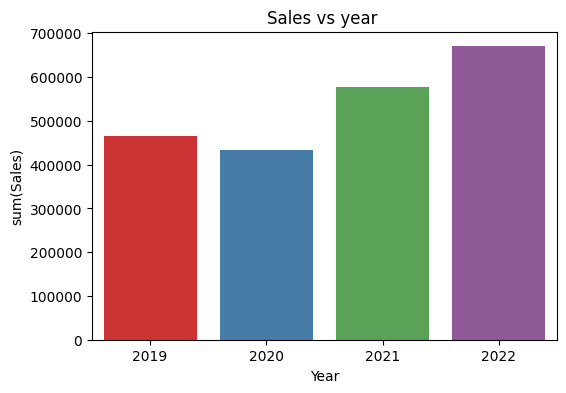

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x = sales_year["Year"], y = sales_year["sum(Sales)"] ,data = sales_year,palette='Set1').set(title="Sales vs year ")


[Text(0.5, 1.0, 'Sale vs Year')]

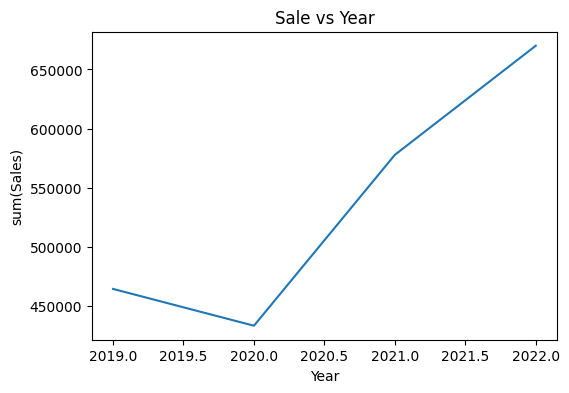

In [ ]:
plt.figure(figsize=(6,4))
sns.lineplot(x = sales_year["Year"] , y = sales_year["sum(Sales)"], data = sales_year).set(title = "Sale vs Year")


[Text(0.5, 1.0, 'Profits vs year ')]

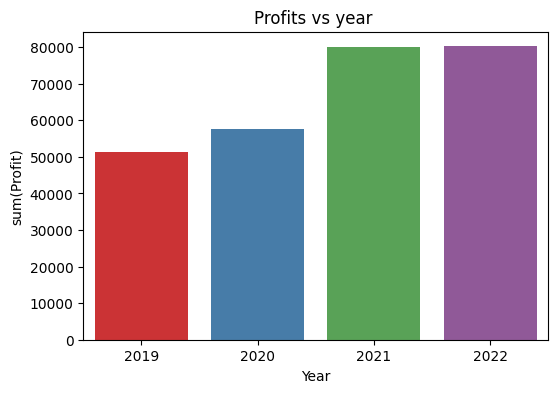

In [ ]:
#profit vs year

plt.figure(figsize=(6,4))
sns.barplot(x = sales_year["Year"], y = sales_year["sum(Profit)"] ,data = sales_year,palette='Set1').set(title="Profits vs year ")




In [ ]:
sales_cate = sales_table.distinct().join(product_table, sales_table.Product_ID == product_table.Product_ID, "inner")
sales_cate = sales_cate.withColumn("Year",year(("Order_Date")))
sales_cate = sales_cate.groupBy("Year","Category").sum("Sales", "Quantity", "Profit" )

sales_cate = sales_cate.orderBy("Year", ascending = True)
#sales_cate.show()

sales_cate = sales_cate.toPandas()
sales_cate = sales_cate.loc[:,~sales_cate.columns.duplicated()].copy()
sales_cate

,Year,Category,sum(Sales),sum(Quantity),sum(Profit)
0,2019,Office Supplies,143626.5300,4362,24884.7338
1,2019,Furniture,153047.4171,1605,6149.7371
2,2019,Technology,167766.2250,1311,20155.7921
3,2020,Furniture,158554.3410,1686,2708.2187
4,2020,Office Supplies,129506.4110,4430,23215.5351
5,2020,Technology,145271.3850,1372,31675.1857
6,2021,Technology,217826.9720,1590,39823.3296
7,2021,Furniture,185667.7450,2107,6684.2696
8,2021,Office Supplies,174317.0910,5531,33545.2169
9,2022,Technology,236320.5230,2180,40891.7214


[Text(0.5, 1.0, 'profit variation in each category in each year ')]

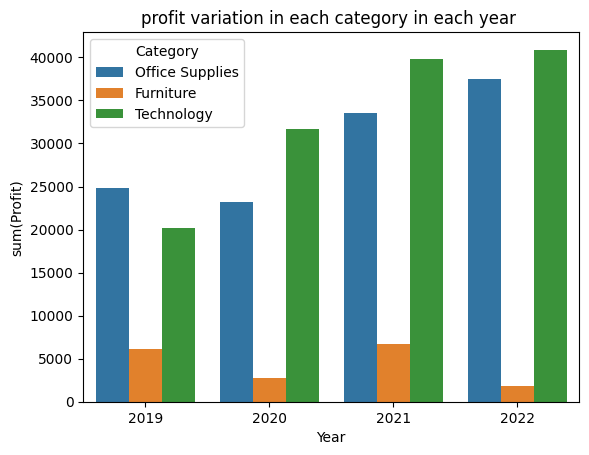

In [ ]:
sns.barplot(x='Year',hue='Category',y='sum(Profit)',data=sales_cate).set(title="profit variation in each category in each year ")

## Create a model to predict a future week's quantity of items to be shipped given a segment

we use sarima model for predictions

**model for segment = consumer**

In [ ]:
data = sales_data.toPandas()

In [ ]:
for i in range(len(data)):
  if len(data["Order_Week"][i]) == 6:
    data["Order_Week"][i] = data["Order_Week"][i][:5] + "0" + data["Order_Week"][i][5:]

  data["Order_Week"][i] = data["Order_Week"][i][:4] + " " + data["Order_Week"][i][5:] + " 1"

data["Order_Week"][i] = pd.to_datetime(data["Order_Week"][i], format='%Y %U %w')

In [ ]:
#collecting data for model
X = data.groupby(["Order_Week","Segment"]).sum()
X = X.reset_index(level=[1])
X = X[["Segment","Quantity"]][1:]

X_Consumer = X.loc[X["Segment"] == "Consumer"]
X_Consumer = X_Consumer.drop("Segment", axis=1)

In [ ]:
#allocating data for train and test
train = X_Consumer[: len(X_Consumer)-53]
test = X_Consumer[len(X_Consumer)-53 :]

In [ ]:
fig = px.line(train, x=train.index, y=train["Quantity"])
fig.show()
#fig.update_layout(title_text='Quantity Sold with time')


It looks seasonal

In [ ]:
# Testing For Stationary


from statsmodels.tsa.stattools import adfuller

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")



adfuller_test(train["Quantity"])



ADF Test Statistic : -5.104527994879977
p-value : 1.3728049554475726e-05
#Lags Used : 1
Number of Observations Used : 156
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


So it is stationary we can build a model in SARIMAX

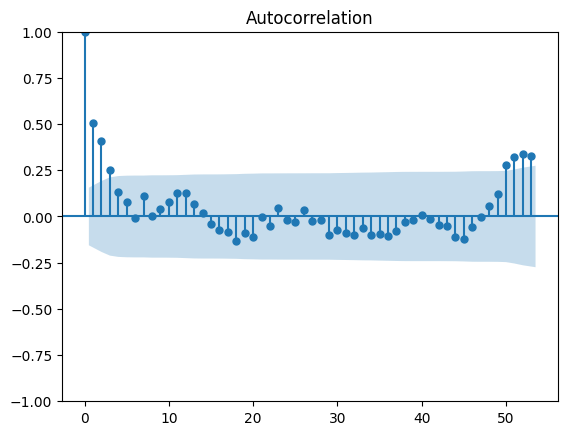

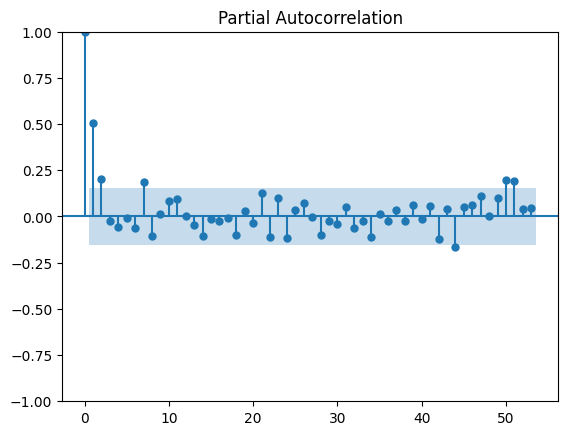

In [ ]:
#ploting autocorrelation and partial autocorrelation graph
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train["Quantity"], lags=53)
plot_pacf(train["Quantity"], lags=53)
plt.show()

In [ ]:
pip install pmdarima

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

Sarimax_model = auto_arima(train["Quantity"],
                       start_P=1,
                       start_q=1,
                       max_p=2,
                       max_q=3,
                       m=52,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[52] intercept   : AIC=1114.341, Time=49.13 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1131.382, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=6.88 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=12.75 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1131.036, Time=0.16 sec
 ARIMA(2,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=27.04 sec
 ARIMA(2,0,1)(1,1,0)[52] intercept   : AIC=1112.342, Time=14.06 sec
 ARIMA(2,0,1)(0,1,0)[52] intercept   : AIC=1132.875, Time=3.83 sec
 ARIMA(2,0,1)(2,1,0)[52] intercept   : AIC=1114.334, Time=69.31 sec
 ARIMA(2,0,1)(2,1,1)[52] intercept   : AIC=inf, Time=99.23 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=inf, Time=22.41 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=inf, Time=11.46 sec
 ARIMA(2,0,2)(1,1,0)[52] intercept   : AIC=inf, Time=28.66 sec
 ARIMA(1,0,2)(1,1,0)[52] intercept   : AIC=inf, Time=19.62 sec
 ARIMA(2,0,1)(1,1,0)[52]             : AIC=1116.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  158
Model:             SARIMAX(2, 0, 1)x(1, 1, [], 52)   Log Likelihood                -550.171
Date:                             Fri, 08 Sep 2023   AIC                           1112.342
Time:                                     17:46:28   BIC                           1128.322
Sample:                                          0   HQIC                          1118.819
                                             - 158                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.4048      3.239      1.051      0.293      -2.944       9.754
ar.L1          0.7595      0.281      2.700      0.007       0.208       1.311
ar.L2         -0.1025      0.108     -0.952      0.341      -0.313       0.108
ma.L1         -0.7730      0.256     -3.021      0.003      -1.274      -0.272
ar.S.L52      -0.5967      0.093     -6.412      0.000      -0.779      -0.414
sigma2      1521.0992    261.130      5.825      0.000    1009.295    2032.904
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.42
Prob(Q):                              0.93   Prob(JB):                         0.18
Heteroskedasticity (H):               1.93   Skew:                            -0.13
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#building the model
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train["Quantity"], order=(2,0,1),
                 seasonal_order = (1,1,0,52),
                 enforce_stationarity = False,
                 enforce_invertibility = False)

model = model.fit(disp=-1)
print(model.summary().tables[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7705      0.189      4.083      0.000       0.401       1.140
ar.L2          0.1567      0.139      1.125      0.261      -0.116       0.430
ma.L1         -0.8497      0.183     -4.636      0.000      -1.209      -0.490
ar.S.L52      -0.5442      0.082     -6.630      0.000      -0.705      -0.383
sigma2      1208.1538    246.668      4.898      0.000     724.693    1691.615


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



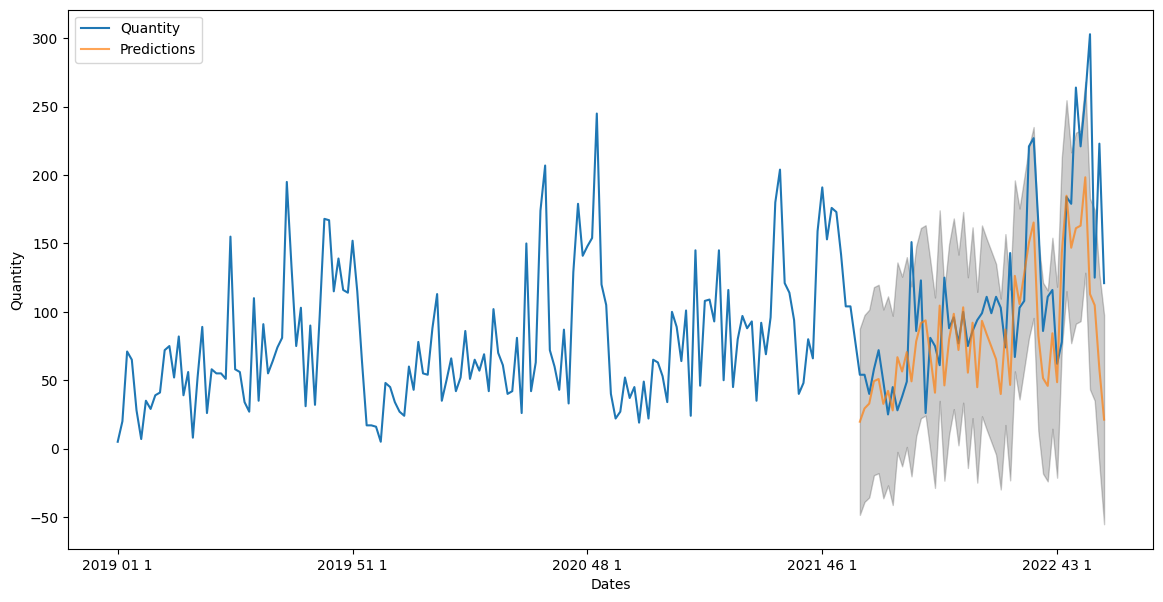

In [ ]:
#prediction
forecast = model.get_forecast(steps=53)

predictions = forecast.predicted_mean
ci = forecast.conf_int()

fig = X_Consumer.plot(label = "Observed", figsize = (14,7))
fig.set_xlabel("Dates")
fig.set_ylabel("Quantity")
fig.fill_between(ci.index,
                 ci.iloc[:, 0],
                 ci.iloc[:, 1], color = "k", alpha=0.2)

predictions.plot(ax=fig, label="Predictions", alpha=0.7, figsize = (14,7))

plt.legend()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm


# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)



print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)



Mean Absolute Error (MAE): 35.97933513548408
Mean Squared Error (MSE): 2602.1588899104804
Root Mean Squared Error (RMSE): 51.011360400507655


 **Using SARIMAX Model for Prediction (Segment = Home Office) **

In [ ]:
#collecting data for model
X = data.groupby(["Order_Week","Segment"]).sum()
X = X.reset_index(level=[1])
X = X[["Segment","Quantity"]][1:]

X_Home = X.loc[X["Segment"] == "Home Office"]
X_Home = X_Home.drop("Segment", axis=1)

In [ ]:
train = X_Home[: len(X_Home)-53]
test = X_Home[len(X_Home)-53 :]

In [ ]:
fig = px.line(train, x=train.index, y=train["Quantity"])
#fig.show()
fig.update_layout(title_text='Quantity Sold with time')


In [ ]:
adfuller_test(train["Quantity"])

ADF Test Statistic : -9.584956239795389
p-value : 2.109358847716661e-16
#Lags Used : 0
Number of Observations Used : 147
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


We can observe a p-value < 0.05 and therefore we can conclude that the data is stationary and hence go for an SARIMAX type Model

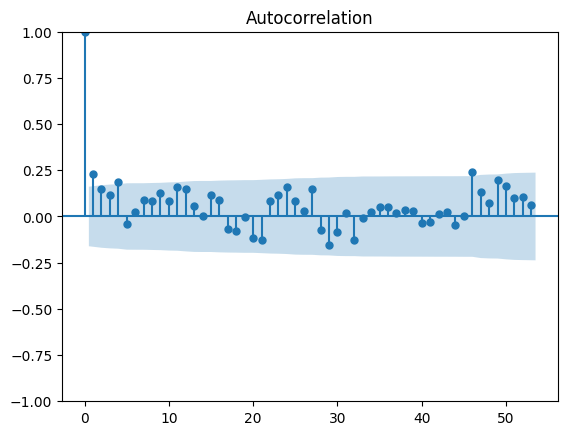

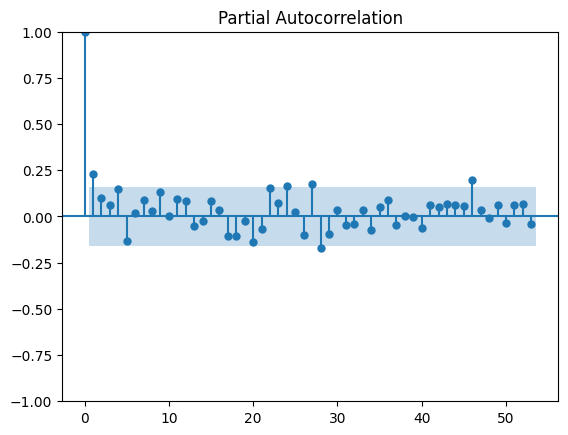

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train["Quantity"], lags=53)
plot_pacf(train["Quantity"], lags=53)
plt.show()

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
Sarimax_model = auto_arima(train["Quantity"],
                       start_P=1,
                       start_q=1,
                       max_p=2,
                       max_q=3,
                       m=52,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=29.70 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=901.683, Time=0.18 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=893.125, Time=8.99 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=893.189, Time=9.67 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=902.284, Time=0.19 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=898.392, Time=0.95 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=inf, Time=28.17 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=895.124, Time=10.52 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=893.123, Time=7.48 sec
 ARIMA(1,0,0)(0,1,2)[52] intercept   : AIC=inf, Time=29.57 sec
 ARIMA(1,0,0)(1,1,2)[52] intercept   : AIC=inf, Time=76.90 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=7.60 sec
 ARIMA(2,0,0)(0,1,1)[52] intercept   : AIC=895.088, Time=11.95 sec
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=895.101, Time=9.95 sec
 ARIMA(2,0,1)(0,1,1)[52] intercept   : AIC=896.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  148
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 52)   Log Likelihood                -442.562
Date:                              Thu, 09 Mar 2023   AIC                            893.123
Time:                                      05:04:00   BIC                            903.381
Sample:                                           0   HQIC                           897.269
                                              - 148                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.6823      2.202      1.672      0.094      -0.634       7.998
ar.L1          0.1853      0.116      1.593      0.111      -0.043       0.413
ma.S.L52      -0.5198      0.369     -1.409      0.159      -1.243       0.203
sigma2       506.0867    137.759      3.674      0.000     236.083     776.090
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.49
Prob(Q):                              0.96   Prob(JB):                         0.06
Heteroskedasticity (H):               1.72   Skew:                             0.57
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train["Quantity"], order=(1,0,0),
                 seasonal_order = (0,1,1,52),
                 enforce_stationarity = False,
                 enforce_invertibility = False)

model = model.fit(disp=-1)
print(model.summary().tables[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2832      0.272      1.040      0.299      -0.251       0.817
ma.S.L52      -0.6739      0.739     -0.912      0.362      -2.122       0.774
sigma2       543.3273    270.386      2.009      0.044      13.380    1073.275


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



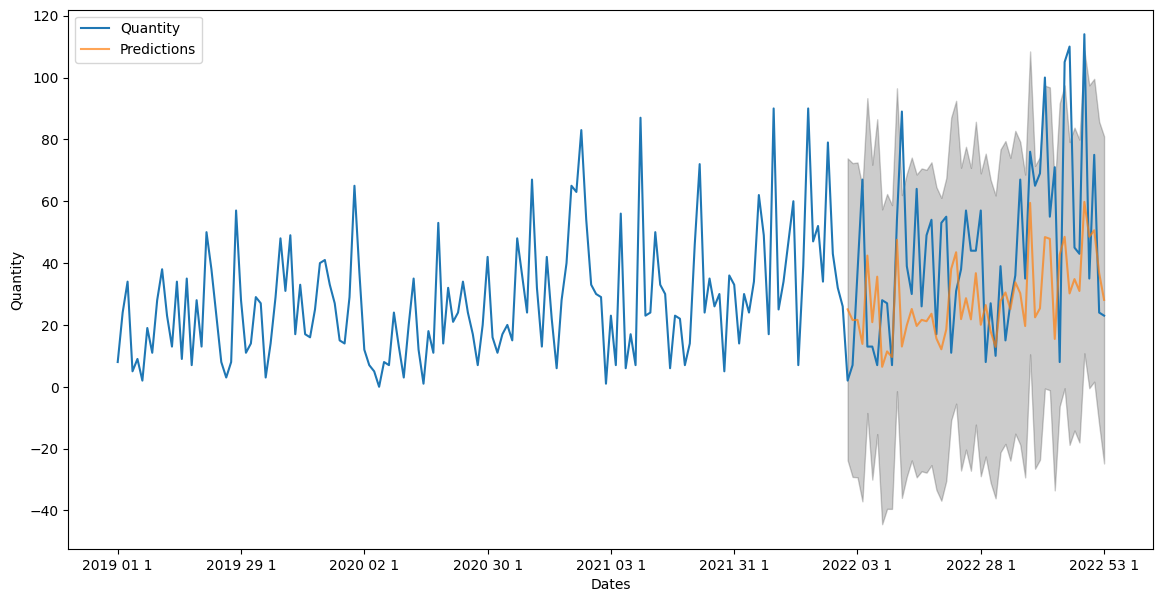

In [ ]:
forecast = model.get_forecast(steps=53)

predictions = forecast.predicted_mean
ci = forecast.conf_int()

fig = X_Home.plot(label = "Observed", figsize = (14,7))
fig.set_xlabel("Dates")
fig.set_ylabel("Quantity")
fig.fill_between(ci.index,
                 ci.iloc[:, 0],
                 ci.iloc[:, 1], color = "k", alpha=0.2)

predictions.plot(ax=fig, label="Predictions", alpha=0.7, figsize = (14,7))

plt.legend()
plt.show()

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)



print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 22.409721946523707
Mean Squared Error (MSE): 784.6208322323861
Root Mean Squared Error (RMSE): 28.011084095985755


Using SARIMAX Model for Prediction (Segment = Corporate)

In [ ]:
X = data.groupby(["Order_Week","Segment"]).sum()
X = X.reset_index(level=[1])
X = X[["Segment","Quantity"]][1:]

X_Corporate = X.loc[X["Segment"] == "Corporate"]
X_Corporate = X_Corporate.drop("Segment", axis=1)

In [ ]:
train = X_Corporate[: len(X_Corporate)-52]
test = X_Corporate[len(X_Corporate)-52 :]

In [ ]:
fig = px.line(train, x=train.index, y=train["Quantity"])
#fig.show()
fig.update_layout(title_text='Quantity Sold with time')


In [ ]:
adfuller_test(train["Quantity"])

ADF Test Statistic : -4.8589877700154664
p-value : 4.188485445704505e-05
#Lags Used : 1
Number of Observations Used : 155
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


We can observe a p-value < 0.05 and therefore we can conclude that the data is stationary and hence go for an SARIMAX type Model

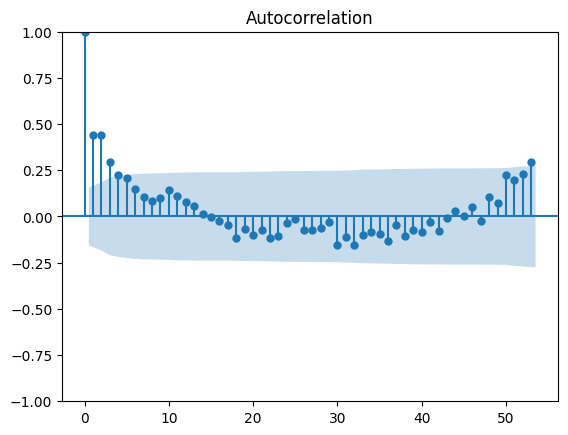

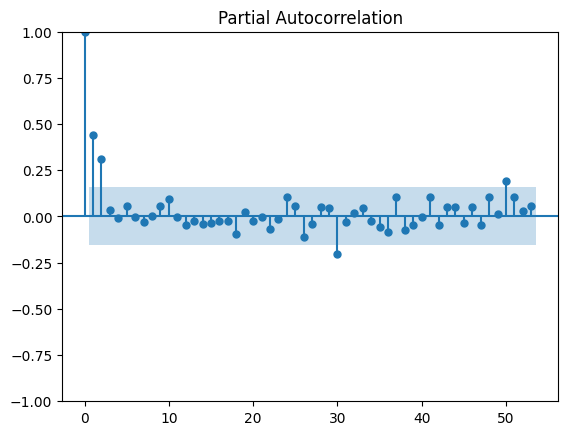

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train["Quantity"], lags=53)
plot_pacf(train["Quantity"], lags=53)
plt.show()

In [ ]:
Sarimax_model = auto_arima(train["Quantity"],
                       start_P=1,
                       start_q=1,
                       max_p=2,
                       max_q=3,
                       m=52,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,1,1)[26] intercept   : AIC=inf, Time=15.83 sec
 ARIMA(0,0,0)(0,1,0)[26] intercept   : AIC=1364.951, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[26] intercept   : AIC=1320.564, Time=3.23 sec
 ARIMA(0,0,1)(0,1,1)[26] intercept   : AIC=inf, Time=3.31 sec
 ARIMA(0,0,0)(0,1,0)[26]             : AIC=1367.524, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[26] intercept   : AIC=1354.034, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[26] intercept   : AIC=1315.201, Time=5.18 sec
 ARIMA(1,0,0)(2,1,1)[26] intercept   : AIC=inf, Time=14.94 sec
 ARIMA(1,0,0)(1,1,1)[26] intercept   : AIC=inf, Time=8.20 sec
 ARIMA(0,0,0)(2,1,0)[26] intercept   : AIC=1317.899, Time=4.25 sec
 ARIMA(2,0,0)(2,1,0)[26] intercept   : AIC=1309.724, Time=9.73 sec
 ARIMA(2,0,0)(1,1,0)[26] intercept   : AIC=1320.032, Time=3.94 sec
 ARIMA(2,0,0)(2,1,1)[26] intercept   : AIC=inf, Time=16.46 sec
 ARIMA(2,0,0)(1,1,1)[26] intercept   : AIC=inf, Time=9.36 sec
 ARIMA(2,0,1)(2,1,0)[26] intercept   : AIC=130

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  157
Model:             SARIMAX(1, 0, 1)x(2, 1, 1, 26)   Log Likelihood                -645.100
Date:                            Thu, 09 Mar 2023   AIC                           1302.199
Time:                                    05:13:33   BIC                           1319.450
Sample:                                         0   HQIC                          1309.209
                                            - 157                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9490      0.063     15.049      0.000       0.825       1.073
ma.L1         -0.7517      0.124     -6.050      0.000      -0.995      -0.508
ar.S.L26      -0.1898      0.290     -0.655      0.512      -0.757       0.378
ar.S.L52      -0.1740      0.234     -0.745      0.456      -0.632       0.284
ma.S.L26      -0.7064      0.395     -1.788      0.074      -1.481       0.068
sigma2       881.5151    144.664      6.094      0.000     597.978    1165.052
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                28.68
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             0.73
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(train["Quantity"], order=(1,0,1),
                 seasonal_order = (2,1,1,52),
                 enforce_stationarity = False,
                 enforce_invertibility = False)



model = model.fit(disp=-1)
print(model.summary().tables[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7833         -0       -inf      0.000       0.783       0.783
ma.L1         -0.6995         -0        inf      0.000      -0.699      -0.699
ar.S.L52            0         -0        nan        nan           0           0
ar.S.L104           0         -0        nan        nan           0           0
ma.S.L52            0         -0        nan        nan           0           0
sigma2      1308.0102         -0       -inf      0.000    1308.010    1308.010


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



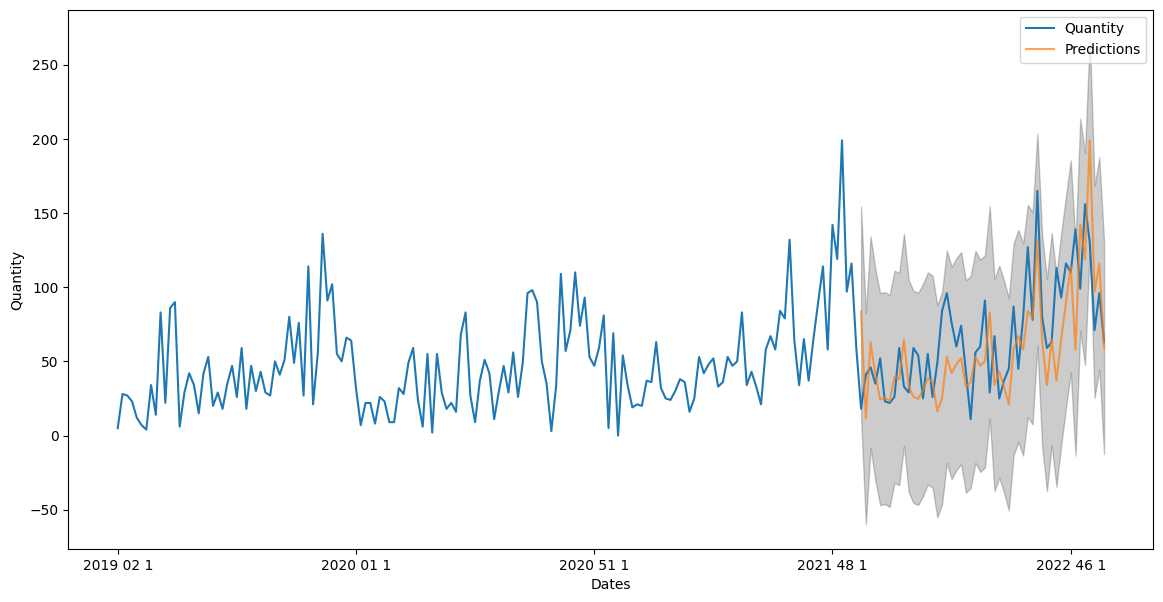

In [ ]:
forecast = model.get_forecast(steps=52)

predictions = forecast.predicted_mean
ci = forecast.conf_int()

fig = X_Corporate.plot(label = "Observed", figsize = (14,7))
fig.set_xlabel("Dates")
fig.set_ylabel("Quantity")
fig.fill_between(ci.index,
                 ci.iloc[:, 0],
                 ci.iloc[:, 1], color = "k", alpha=0.2)

predictions.plot(ax=fig, label="Predictions", alpha=0.7, figsize = (14,7))

plt.legend()
plt.show()

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)



print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 25.90727153058671
Mean Squared Error (MSE): 1045.2900169769307
Root Mean Squared Error (RMSE): 32.33094519151784


**Define a Predict function**

In [ ]:
def predict_quantity(Segment, Week):

  if Segment == "Consumer":
    count = 210

    l = 53
    p = 2
    q = 1
    lag = 52
    a = 1
    b = 1
    c = 0

  elif Segment == "Home Office":
    count = 201

    l = 53
    p = 1
    q = 0
    lag = 52
    a = 0
    b = 1
    c = 1


  else:
    count = 208

    l = 51
    p = 1
    q = 1
    lag = 52
    a = 2
    b = 1
    c = 1



  X = data.groupby(["Order_Week","Segment"]).sum()
  X = X.reset_index(level=[1])
  X = X[["Segment","Quantity"]][1:]

  X = X.loc[X["Segment"] == Segment ]
  X = X.drop("Segment", axis=1)

  train = X[: len(X)-l]


  model = sm.tsa.statespace.SARIMAX(train["Quantity"], order = (p,0,q),
                 seasonal_order = (a,b,c,lag),
                 enforce_stationarity = False,
                 enforce_invertibility = False)

  model = model.fit(disp=-1)

  forecast = model.get_forecast(steps = Week)

  predictions = forecast.predicted_mean
  ci = forecast.conf_int()


  Prediction = model.forecast(steps=53)


  print("Predicted Sales Quantity for " + str(Week) + " weeks ahead: " + str(int(Prediction.values[-1])))



prediction function which allows the user to predict the sales quantity for a given number of weeks.

**Function**: Predict_Segment_Quantity(Segment,Week)






## Predict

In [ ]:
#example
predict_quantity("Consumer",22)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



Predicted Sales Quantity for 22 weeks ahead: 21


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



# **To Improve our model**

1. **Model Selection**: SARIMA models have several hyperparameters, including the order of autoregressive (p), differencing (d), and moving average (q) terms, as well as the seasonal order (P, D, Q, and S). here we use  auto ARIMA to find the best combination of these parameters that minimize the model's error.
we can use techniques like grid search.


2. **Feature Engineering:** Consider incorporating additional relevant features that may impact  time series data. For example, we can include external factors like holidays, economic indicators, or weather data if they have a significant influence on our sales or demand.

3. **Outliers and Anomalies Handling:** Identify and handle outliers or anomalies in your data. These unusual data points can negatively affect model accuracy. Techniques like outlier detection or robust modeling can be applied.

4. **Error Analysis:** Analyze the model's errors, such as examining the residuals (differences between predictions and actual values). Look for patterns in the residuals, as this may suggest areas where the model could be improved.

5. **Advanced Techniques:**  we can explore machine learning models like  LSTM, or Prophet for time series forecasting. These models can capture complex patterns in the data.